# 流变性能预测 - 基于广义Maxwell模型的曲线级别学习

In [56]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子以确保可重复性
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("✅ 环境配置完成")

使用设备: cpu
✅ 环境配置完成


In [57]:
# ============================================================================
# 数据集类：曲线级别组织
# ============================================================================

class RheologyCurveDataset:
    """
    将数据组织成曲线级别，每个样本是一条完整的频率扫描曲线
    """
    
    def __init__(self, csv_path: str):
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """处理数据并组织成曲线格式"""
        df = self.df
        
        # 过滤异常值
        df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
        df = df[(df['tan_delta'] >= 0) & (df['tan_delta'] <= 10)].copy()
        
        # 特征工程（样本级别，不包括频率）
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_Mw'] = np.log10(df['Mw'])
        df['log_Mn'] = np.log10(df['Mn'])
        df['PDI'] = df['Mw'] / df['Mn']
        df['log_c'] = np.log10(df['c'])
        
        # WLF时温等效
        T_ref = 25
        C1 = 8.86
        C2 = 101.6
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # 对数转换
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # 样本级别特征（不包括频率相关的）
        self.sample_feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C',
            'temp_inv', 'T_x_aspect', 'aT',
            'log_Mw', 'log_Mn', 'PDI', 'log_c'
        ]
        
        # 按(样本ID, 温度)组合分组，确保每个样本对应唯一的测试条件
        self.samples = []
        self.sample_ids = []
        
        for (sample_id, temp) in df.groupby(['Sample_ID', 'Temp_C']).groups.keys():
            sample_df = df[(df['Sample_ID'] == sample_id) & (df['Temp_C'] == temp)].sort_values('Freq_rad_s')
            
            # 确保有足够的数据点
            if len(sample_df) < 10:
                continue
                
            # 提取样本特征（第一行的特征，因为在同一温度下它们对整个曲线都相同）
            sample_features = sample_df[self.sample_feature_cols].iloc[0].values
            
            # 创建唯一的样本标识符（包含温度信息）
            unique_sample_id = f"{sample_id}_T{int(temp)}"
            
            # 提取频率扫描数据
            frequencies = sample_df['Freq_rad_s'].values
            log_frequencies = sample_df['log_freq'].values
            log_G1 = sample_df['log_G1'].values
            log_G2 = sample_df['log_G2'].values
            
            self.samples.append({
                'features': sample_features,
                'frequencies': frequencies,
                'log_frequencies': log_frequencies,
                'log_G1': log_G1,
                'log_G2': log_G2,
                'sample_id': unique_sample_id
            })
            self.sample_ids.append(unique_sample_id)
        
        print(f"\n数据统计:")
        print(f"总样本数: {len(self.samples)}")
        print(f"样本特征维度: {len(self.sample_feature_cols)}")
        print(f"平均频率点数: {np.mean([len(s['frequencies']) for s in self.samples]):.1f}")
        
        # 标准化样本特征
        self.scaler_X = StandardScaler()
        
        all_features = np.array([s['features'] for s in self.samples])
        self.scaler_X.fit(all_features)
        
        print("\n特征标准化参数:")
        for name, scale, mean in zip(self.sample_feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"  {name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # 分割训练集和验证集（样本级别）
        train_indices, val_indices = train_test_split(
            range(len(self.samples)), test_size=0.2, random_state=RANDOM_SEED
        )
        
        # 保存索引（可能用于其他分析）
        self.train_indices = train_indices
        self.val_indices = val_indices
        
        self.train_samples = [self.samples[i] for i in train_indices]
        self.val_samples = [self.samples[i] for i in val_indices]
        
        print(f"\n训练样本数: {len(self.train_samples)}")
        print(f"验证样本数: {len(self.val_samples)}")


# ============================================================================
# Maxwell模型：基于广义Maxwell模型的流变曲线预测器
# ============================================================================

class MaxwellCurvePredictor(nn.Module):
    """
    基于广义Maxwell模型的流变曲线预测器
    
    输入：样本的几何和材料参数（长度、宽度、温度、分子量等）
    输出：Maxwell模型的参数（多个松弛模式的强度和松弛时间）
    
    广义Maxwell模型：
    G'(ω) = Σ[G_i * (ω*τ_i)² / (1 + (ω*τ_i)²)]
    G"(ω) = Σ[G_i * (ω*τ_i) / (1 + (ω*τ_i)²)]
    """
    
    def __init__(self, input_dim: int, n_modes: int = 5, hidden_dim: int = 128):
        """
        Args:
            input_dim: 输入特征维度
            n_modes: Maxwell模型的松弛模式数量
            hidden_dim: 隐藏层维度
        """
        super(MaxwellCurvePredictor, self).__init__()
        
        self.n_modes = n_modes
        
        # 共享特征提取器
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )
        
        # 预测松弛强度 G_i（必须为正）
        self.modulus_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_modes),
            nn.Softplus()  # 确保为正
        )
        
        # 预测松弛时间 τ_i 的对数（覆盖宽频率范围）
        self.tau_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_modes),
        )
        
    def forward(self, x: torch.Tensor) -> tuple:
        """
        Args:
            x: 输入特征 [batch_size, input_dim]
            
        Returns:
            G_modes: 松弛强度 [batch_size, n_modes]
            log_tau_modes: 松弛时间的对数 [batch_size, n_modes]
        """
        features = self.feature_extractor(x)
        
        # 预测每个松弛模式的参数
        G_modes = self.modulus_predictor(features)  # [batch, n_modes]
        log_tau_modes = self.tau_predictor(features)  # [batch, n_modes]
        
        return G_modes, log_tau_modes
    
    def predict_curve(self, x: torch.Tensor, omega: torch.Tensor) -> tuple:
        """
        根据输入特征预测完整的流变曲线
        
        Args:
            x: 输入特征 [batch_size, input_dim]
            omega: 角频率数组 [n_freq]
            
        Returns:
            G_prime: 储能模量 [batch_size, n_freq]
            G_double_prime: 损耗模量 [batch_size, n_freq]
        """
        # 获取Maxwell模型参数
        G_modes, log_tau_modes = self.forward(x)  # [batch, n_modes]
        tau_modes = torch.exp(log_tau_modes)  # [batch, n_modes]
        
        # 扩展维度以便广播：[batch, n_modes, 1] 和 [1, n_freq]
        G = G_modes.unsqueeze(-1)  # [batch, n_modes, 1]
        tau = tau_modes.unsqueeze(-1)  # [batch, n_modes, 1]
        omega = omega.unsqueeze(0).unsqueeze(0)  # [1, 1, n_freq]
        
        # 计算每个模式的贡献
        omega_tau = omega * tau  # [batch, n_modes, n_freq]
        omega_tau_sq = omega_tau ** 2
        
        # Maxwell模型公式
        G_prime_modes = G * omega_tau_sq / (1 + omega_tau_sq)  # [batch, n_modes, n_freq]
        G_double_prime_modes = G * omega_tau / (1 + omega_tau_sq)
        
        # 叠加所有模式
        G_prime = G_prime_modes.sum(dim=1)  # [batch, n_freq]
        G_double_prime = G_double_prime_modes.sum(dim=1)
        
        return G_prime, G_double_prime


print("=" * 80)
print("✅ 数据集类和Maxwell模型已定义")
print("=" * 80)

✅ 数据集类和Maxwell模型已定义


In [58]:
# ============================================================================
# 训练函数：曲线级别学习
# ============================================================================

def train_curve_model(model, curve_dataset, epochs=500, lr=1e-3):
    """
    训练基于曲线的Maxwell模型
    
    Args:
        model: MaxwellCurvePredictor实例
        curve_dataset: RheologyCurveDataset实例
        epochs: 训练轮数
        lr: 学习率
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print("\n开始训练曲线级别模型...")
    print("=" * 80)
    
    for epoch in range(epochs):
        # ====== 训练阶段 ======
        model.train()
        epoch_train_losses = []
        
        # 随机打乱训练样本
        np.random.shuffle(curve_dataset.train_samples)
        
        for sample in curve_dataset.train_samples:
            # 准备数据
            features = torch.FloatTensor(
                curve_dataset.scaler_X.transform([sample['features']])
            ).to(device)
            
            frequencies = torch.FloatTensor(sample['frequencies']).to(device)
            log_G1_true = torch.FloatTensor(sample['log_G1']).to(device)
            log_G2_true = torch.FloatTensor(sample['log_G2']).to(device)
            
            # 前向传播：预测整条曲线
            G_prime_pred, G_double_prime_pred = model.predict_curve(features, frequencies)
            
            # 转换到对数空间计算损失
            log_G1_pred = torch.log10(G_prime_pred.squeeze() + 1e-10)
            log_G2_pred = torch.log10(G_double_prime_pred.squeeze() + 1e-10)
            
            # 曲线级别的损失
            loss_G1 = torch.mean((log_G1_pred - log_G1_true) ** 2)
            loss_G2 = torch.mean((log_G2_pred - log_G2_true) ** 2)
            
            # 物理约束：确保 G' 和 G" 的单调性
            # G' 应随频率单调递增，G" 可以有一个峰值但整体趋势应合理
            physics_loss = 0.0
            if len(frequencies) > 3:
                # G' 单调性约束：相邻点的差值应为正（递增）
                G_prime_diff = G_prime_pred[0, 1:] - G_prime_pred[0, :-1]
                monotonicity_G1 = torch.mean(torch.relu(-G_prime_diff))  # 惩罚递减
                
                # G" 单调性约束：对于典型的聚合物，G" 在低频递增，高频递减
                # 我们可以放宽约束，只要求不要有剧烈的非单调变化
                G_double_prime_diff = torch.abs(G_double_prime_pred[0, 1:] - G_double_prime_pred[0, :-1])
                # 避免剧烈振荡
                smoothness_G2 = torch.mean(torch.relu(G_double_prime_diff - torch.mean(G_double_prime_diff) * 3))
                
                physics_loss = monotonicity_G1 * 0.1 + smoothness_G2 * 0.05
            
            # 总损失
            total_loss = loss_G1 + loss_G2 + physics_loss
            
            # 反向传播
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_losses.append(total_loss.item())
        
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # ====== 验证阶段 ======
        model.eval()
        epoch_val_losses = []
        
        with torch.no_grad():
            for sample in curve_dataset.val_samples:
                features = torch.FloatTensor(
                    curve_dataset.scaler_X.transform([sample['features']])
                ).to(device)
                
                frequencies = torch.FloatTensor(sample['frequencies']).to(device)
                log_G1_true = torch.FloatTensor(sample['log_G1']).to(device)
                log_G2_true = torch.FloatTensor(sample['log_G2']).to(device)
                
                G_prime_pred, G_double_prime_pred = model.predict_curve(features, frequencies)
                
                log_G1_pred = torch.log10(G_prime_pred.squeeze() + 1e-10)
                log_G2_pred = torch.log10(G_double_prime_pred.squeeze() + 1e-10)
                
                val_loss = torch.mean((log_G1_pred - log_G1_true) ** 2) + \
                          torch.mean((log_G2_pred - log_G2_true) ** 2)
                
                epoch_val_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)
        
        # 更新学习率
        scheduler.step()
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # 打印进度
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    print(f"\n✅ 训练完成！最佳验证损失: {best_val_loss:.4f}")
    
    # 绘制训练曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE in log space)')
    plt.title('Training History - Maxwell Curve Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses


print("=" * 80)
print("✅ 训练函数已定义")
print("=" * 80)

✅ 训练函数已定义


正在加载和处理数据...

数据统计:
总样本数: 71
样本特征维度: 11
平均频率点数: 21.5

特征标准化参数:
  Length_nm: scale=98.3379, mean=115.2817
  Width_nm: scale=4.8000, mean=25.4448
  aspect_ratio: scale=4.8259, mean=5.0446
  Temp_C: scale=7.1422, mean=24.7887
  temp_inv: scale=0.0001, mean=0.0034
  T_x_aspect: scale=130.5644, mean=125.8270
  aT: scale=3.4597, mean=2.8571
  log_Mw: scale=0.3159, mean=6.7029
  log_Mn: scale=0.3032, mean=6.7096
  PDI: scale=0.0660, mean=0.9876
  log_c: scale=1.0000, mean=-1.2218

训练样本数: 56
验证样本数: 15

模型参数:
  输入维度: 11
  Maxwell模式数: 6
  总参数量: 52,620

开始训练曲线级别模型...
Epoch [1/500] Train Loss: 5.7938 | Val Loss: 4.5181 | LR: 0.001000
Epoch [50/500] Train Loss: 0.1701 | Val Loss: 0.2967 | LR: 0.000976
Epoch [50/500] Train Loss: 0.1701 | Val Loss: 0.2967 | LR: 0.000976
Epoch [100/500] Train Loss: 0.1672 | Val Loss: 0.9431 | LR: 0.000905
Epoch [100/500] Train Loss: 0.1672 | Val Loss: 0.9431 | LR: 0.000905
Epoch [150/500] Train Loss: 0.1082 | Val Loss: 0.9015 | LR: 0.000794
Epoch [150/500] Train Loss:

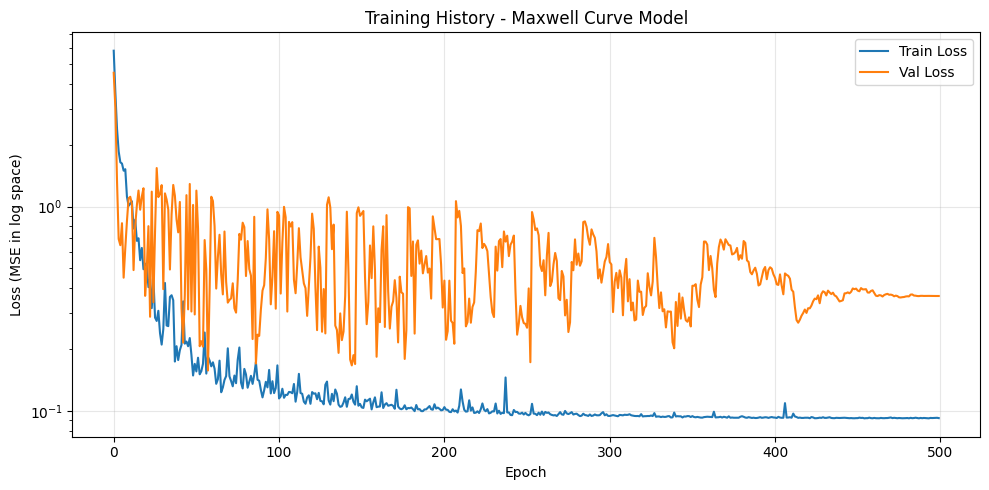

In [59]:
# ============================================================================
# 加载数据并训练模型
# ============================================================================

# 1. 创建曲线数据集
print("正在加载和处理数据...")
curve_dataset = RheologyCurveDataset("PB_Data.csv")

# 2. 创建模型
n_modes = 6  # 使用6个Maxwell模式
input_dim = len(curve_dataset.sample_feature_cols)
curve_model = MaxwellCurvePredictor(input_dim=input_dim, n_modes=n_modes, hidden_dim=128).to(device)

print(f"\n模型参数:")
print(f"  输入维度: {input_dim}")
print(f"  Maxwell模式数: {n_modes}")
print(f"  总参数量: {sum(p.numel() for p in curve_model.parameters()):,}")

# 3. 训练模型
train_losses_curve, val_losses_curve = train_curve_model(
    curve_model, 
    curve_dataset, 
    epochs=500, 
    lr=1e-3
)

Validation Set Evaluation

Selected 3 samples from validation set:
1. 409C_T20: L=30.0nm, W=30.8nm, L/W=0.98
2. 407A_T15: L=100.0nm, W=15.9nm, L/W=6.31
3. 356C_T35: L=300.0nm, W=17.6nm, L/W=17.04


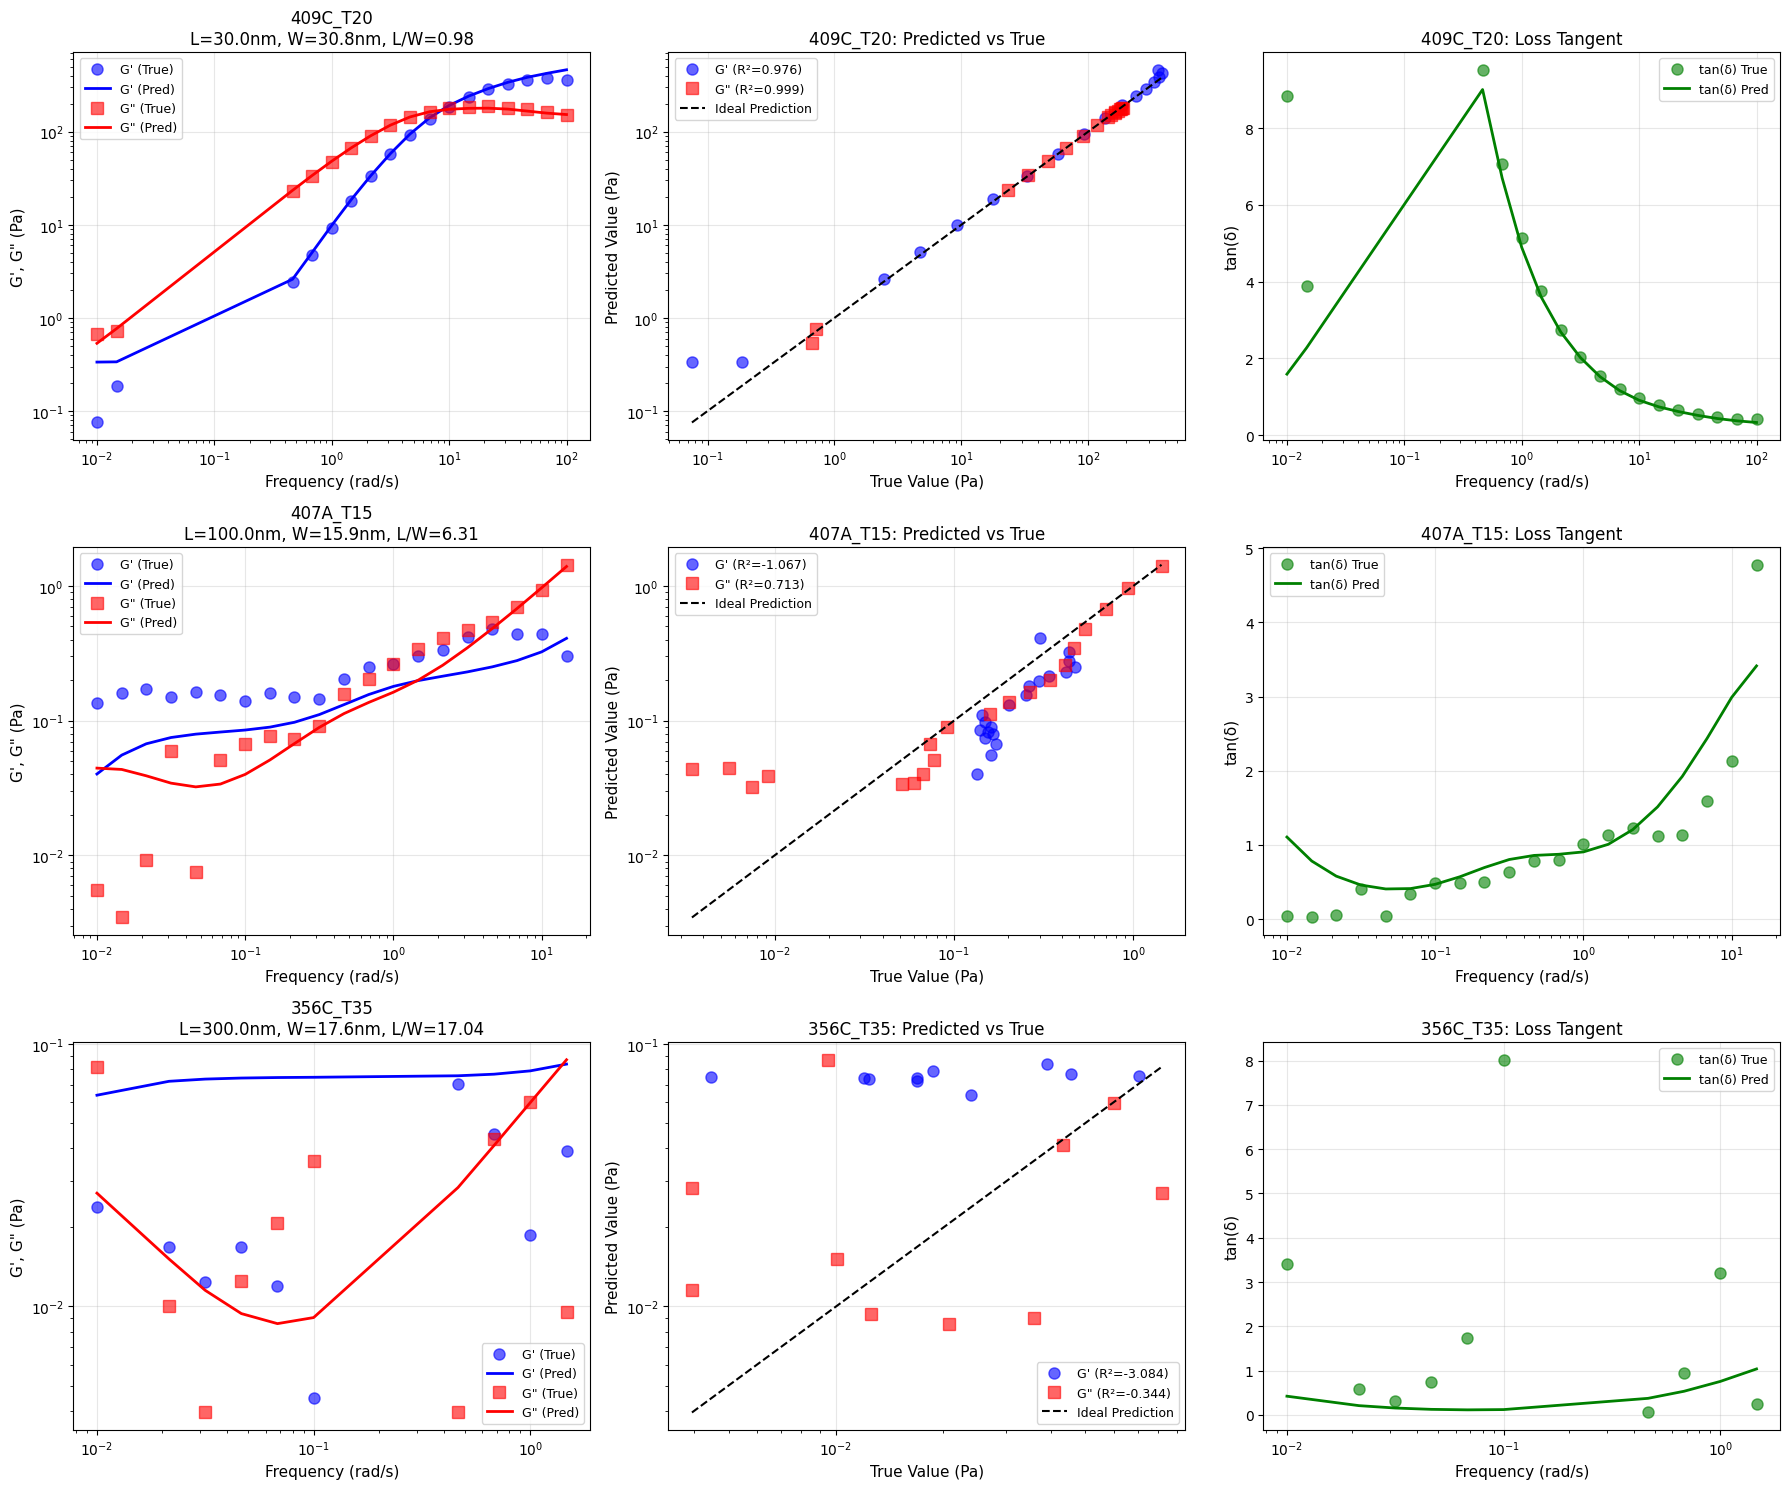


Evaluation Results Summary:
sample_id  length  width  aspect_ratio  R2_G_prime  R2_G_double_prime    R2_avg
 409C_T20    30.0  30.75      0.975610    0.976392           0.998795  0.987593
 407A_T15   100.0  15.86      6.305170   -1.066882           0.713412 -0.176735
 356C_T35   300.0  17.61     17.035775   -3.083553          -0.344134 -1.713843

Average R² Score: -0.3010
⚠️  Model performance needs improvement


In [60]:
# ============================================================================
# Validation Set Evaluation: Model Performance on Real Data
# ============================================================================

def evaluate_on_validation_samples(model, curve_dataset, n_samples=3):
    """
    Evaluate model performance on real samples from validation set
    
    Args:
        model: Trained model
        curve_dataset: Dataset object
        n_samples: Number of samples to evaluate
    """
    
    print("=" * 80)
    print("Validation Set Evaluation")
    print("=" * 80)
    
    # Select samples from validation set (samples with different aspect ratios)
    val_samples_info = []
    for sample in curve_dataset.val_samples:
        sample_id = sample['sample_id']
        features = sample['features']
        length = features[0]  # Length_nm
        width = features[1]   # Width_nm
        aspect_ratio = features[2]  # aspect_ratio
        
        val_samples_info.append({
            'sample_id': sample_id,
            'length': length,
            'width': width,
            'aspect_ratio': aspect_ratio,
            'sample': sample
        })
    
    # Sort by aspect ratio and select representative samples
    val_samples_info.sort(key=lambda x: x['aspect_ratio'])
    
    # Select samples with low, medium, and high aspect ratios
    if len(val_samples_info) >= n_samples:
        indices = [0, len(val_samples_info)//2, len(val_samples_info)-1]
        selected_samples = [val_samples_info[i] for i in indices]
    else:
        selected_samples = val_samples_info[:n_samples]
    
    print(f"\nSelected {len(selected_samples)} samples from validation set:")
    for i, info in enumerate(selected_samples):
        print(f"{i+1}. {info['sample_id']}: L={info['length']:.1f}nm, W={info['width']:.1f}nm, L/W={info['aspect_ratio']:.2f}")
    
    # Evaluate each sample
    model.eval()
    results = []
    
    fig, axes = plt.subplots(len(selected_samples), 3, figsize=(18, 5*len(selected_samples)))
    if len(selected_samples) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    with torch.no_grad():
        for idx, sample_info in enumerate(selected_samples):
            sample = sample_info['sample']
            sample_id = sample_info['sample_id']
            
            # Prepare data
            features = torch.FloatTensor(
                curve_dataset.scaler_X.transform([sample['features']])
            ).to(device)
            
            frequencies = torch.FloatTensor(sample['frequencies']).to(device)
            log_G1_true = sample['log_G1']
            log_G2_true = sample['log_G2']
            
            # Prediction
            G_prime_pred, G_double_prime_pred = model.predict_curve(features, frequencies)
            
            # Convert to linear space
            G_prime_pred_np = G_prime_pred.cpu().numpy().squeeze()
            G_double_prime_pred_np = G_double_prime_pred.cpu().numpy().squeeze()
            G_prime_true_np = np.power(10, log_G1_true)
            G_double_prime_true_np = np.power(10, log_G2_true)
            
            freq_np = sample['frequencies']
            
            # Calculate R²
            from sklearn.metrics import r2_score
            r2_g1 = r2_score(np.log10(G_prime_true_np), np.log10(G_prime_pred_np))
            r2_g2 = r2_score(np.log10(G_double_prime_true_np), np.log10(G_double_prime_pred_np))
            
            # Plot 1: G' and G" vs Frequency
            axes[idx, 0].loglog(freq_np, G_prime_true_np, 'o', 
                               label="G' (True)", color='blue', markersize=8, alpha=0.6)
            axes[idx, 0].loglog(freq_np, G_prime_pred_np, '-', 
                               label="G' (Pred)", color='blue', linewidth=2)
            axes[idx, 0].loglog(freq_np, G_double_prime_true_np, 's', 
                               label='G" (True)', color='red', markersize=8, alpha=0.6)
            axes[idx, 0].loglog(freq_np, G_double_prime_pred_np, '-', 
                               label='G" (Pred)', color='red', linewidth=2)
            axes[idx, 0].set_xlabel('Frequency (rad/s)', fontsize=11)
            axes[idx, 0].set_ylabel('G\', G" (Pa)', fontsize=11)
            axes[idx, 0].set_title(f'{sample_id}\nL={sample_info["length"]:.1f}nm, W={sample_info["width"]:.1f}nm, L/W={sample_info["aspect_ratio"]:.2f}', 
                                  fontsize=12)
            axes[idx, 0].legend(fontsize=9)
            axes[idx, 0].grid(True, alpha=0.3)
            
            # Plot 2: Predicted vs True (Scatter)
            axes[idx, 1].loglog(G_prime_true_np, G_prime_pred_np, 'o', 
                               label=f"G' (R²={r2_g1:.3f})", color='blue', markersize=8, alpha=0.6)
            axes[idx, 1].loglog(G_double_prime_true_np, G_double_prime_pred_np, 's', 
                               label=f'G" (R²={r2_g2:.3f})', color='red', markersize=8, alpha=0.6)
            
            # Add ideal prediction line
            all_vals = np.concatenate([G_prime_true_np, G_double_prime_true_np])
            min_val, max_val = all_vals.min(), all_vals.max()
            axes[idx, 1].loglog([min_val, max_val], [min_val, max_val], 
                               'k--', label='Ideal Prediction', linewidth=1.5)
            
            axes[idx, 1].set_xlabel('True Value (Pa)', fontsize=11)
            axes[idx, 1].set_ylabel('Predicted Value (Pa)', fontsize=11)
            axes[idx, 1].set_title(f'{sample_id}: Predicted vs True', fontsize=12)
            axes[idx, 1].legend(fontsize=9)
            axes[idx, 1].grid(True, alpha=0.3)
            
            # Plot 3: tan(δ) Comparison
            tan_delta_true = G_double_prime_true_np / G_prime_true_np
            tan_delta_pred = G_double_prime_pred_np / G_prime_pred_np
            
            axes[idx, 2].semilogx(freq_np, tan_delta_true, 'o', 
                                 label='tan(δ) True', color='green', markersize=8, alpha=0.6)
            axes[idx, 2].semilogx(freq_np, tan_delta_pred, '-', 
                                 label='tan(δ) Pred', color='green', linewidth=2)
            axes[idx, 2].set_xlabel('Frequency (rad/s)', fontsize=11)
            axes[idx, 2].set_ylabel('tan(δ)', fontsize=11)
            axes[idx, 2].set_title(f'{sample_id}: Loss Tangent', fontsize=12)
            axes[idx, 2].legend(fontsize=9)
            axes[idx, 2].grid(True, alpha=0.3)
            
            # Save results
            results.append({
                'sample_id': sample_id,
                'length': sample_info['length'],
                'width': sample_info['width'],
                'aspect_ratio': sample_info['aspect_ratio'],
                'R2_G_prime': r2_g1,
                'R2_G_double_prime': r2_g2,
                'R2_avg': (r2_g1 + r2_g2) / 2
            })
    
    plt.tight_layout()
    plt.show()
    
    # Print results summary
    print("\n" + "=" * 80)
    print("Evaluation Results Summary:")
    print("=" * 80)
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    avg_r2 = results_df['R2_avg'].mean()
    print(f"\nAverage R² Score: {avg_r2:.4f}")
    
    if avg_r2 > 0.9:
        print("✅ Excellent model performance on validation set!")
    elif avg_r2 > 0.8:
        print("✅ Good model performance on validation set")
    else:
        print("⚠️  Model performance needs improvement")
    
    return results_df

# Run validation set evaluation
validation_results = evaluate_on_validation_samples(curve_model, curve_dataset, n_samples=3)

预测样品: Sample_411c
样品参数:
  长度: 300 nm
  宽度: 20.94 nm
  长宽比: 14.33
  温度: 25 °C
  浓度: 0.06
  分子量 Mw: 1.26e+07
  分子量 Mn: 1.22e+07


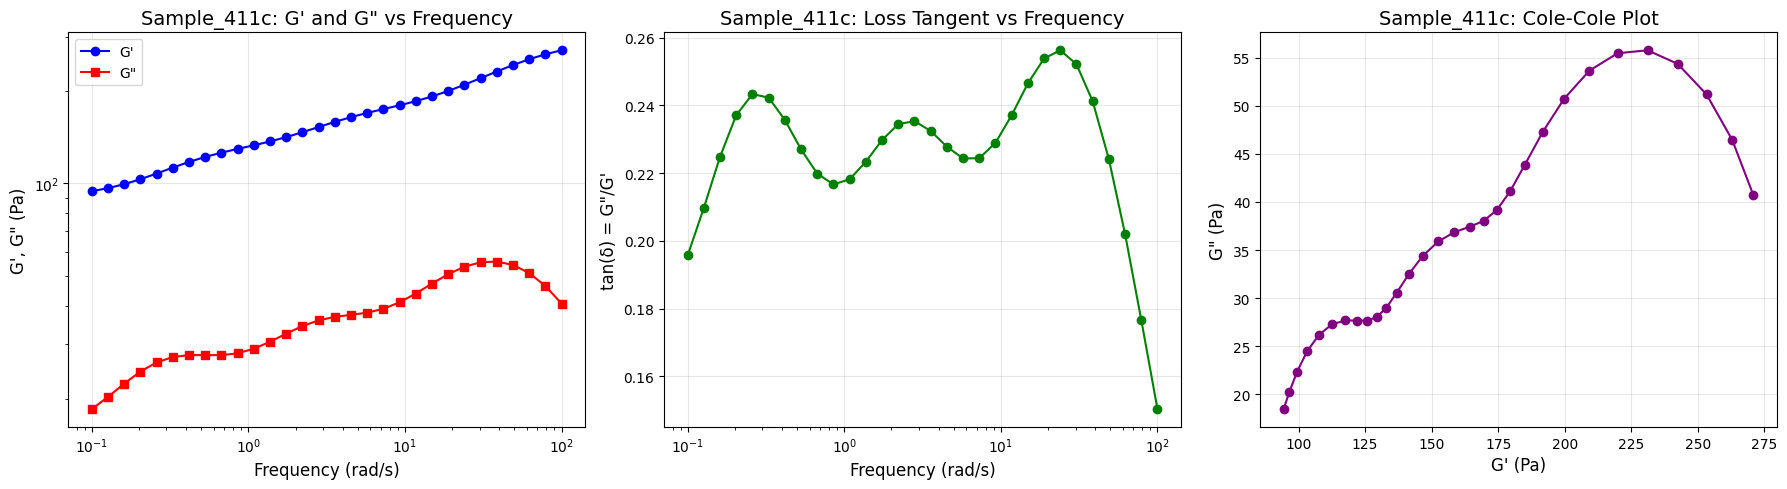


Sample_411c 预测结果摘要:
样品参数:
  长度: 300.00 nm
  宽度: 20.94 nm
  长宽比: 14.33
  温度: 25.0 °C
  浓度: 0.060
  分子量 Mw: 1.26e+07

关键频率点的预测值:
--------------------------------------------------------------------------------
  @ 0.10 rad/s:
    G' = 94.39 Pa
    G" = 18.47 Pa
    tan(δ) = 0.196
  @ 1.08 rad/s:
    G' = 133.04 Pa
    G" = 29.03 Pa
    tan(δ) = 0.218
  @ 9.24 rad/s:
    G' = 179.48 Pa
    G" = 41.09 Pa
    tan(δ) = 0.229
  @ 100.00 rad/s:
    G' = 270.91 Pa
    G" = 40.71 Pa
    tan(δ) = 0.150


In [61]:
# ============================================================================
# 新样本预测
# ============================================================================

def predict_new_sample(model, curve_dataset, sample_name, length_nm, width_nm, 
                       temp_c, concentration, mw, mn,
                       freq_range=(0.1, 100), n_points=30):
    """
    预测新样本的流变曲线
    
    Args:
        model: 训练好的Maxwell模型
        curve_dataset: 数据集对象
        sample_name: 样品名称
        length_nm: 长度 (nm)
        width_nm: 宽度 (nm)
        temp_c: 温度 (°C)
        concentration: 浓度
        mw: 重均分子量
        mn: 数均分子量
        freq_range: 频率范围 (rad/s)，默认(0.1, 100)
        n_points: 频率点数，默认30
        
    Returns:
        results_df: 预测结果DataFrame
    """
    
    # 生成频率点
    frequencies = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), n_points)
    
    # 计算特征
    aspect_ratio = length_nm / width_nm
    
    # WLF时温等效
    T_ref, C1, C2 = 25, 8.86, 101.6
    aT = 10 ** (-C1 * (temp_c - T_ref) / (C2 + temp_c - T_ref))
    temp_inv = 1 / (temp_c + 273.15)
    T_x_aspect = temp_c * aspect_ratio
    
    # 构建特征数组（与训练时的特征顺序一致）
    sample_features = np.array([[
        length_nm, width_nm, aspect_ratio, temp_c,
        temp_inv, T_x_aspect, aT,
        np.log10(mw), np.log10(mn), mw/mn, np.log10(concentration)
    ]])
    
    # 标准化特征
    features_scaled = curve_dataset.scaler_X.transform(sample_features)
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    frequencies_tensor = torch.FloatTensor(frequencies).to(device)
    
    # 预测
    model.eval()
    with torch.no_grad():
        G_prime, G_double_prime = model.predict_curve(features_tensor, frequencies_tensor)
    
    # 转换到numpy
    G_prime_np = G_prime.cpu().numpy().squeeze()
    G_double_prime_np = G_double_prime.cpu().numpy().squeeze()
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'Sample_ID': [sample_name] * n_points,
        'Length_nm': [length_nm] * n_points,
        'Width_nm': [width_nm] * n_points,
        'Temp_C': [temp_c] * n_points,
        'c': [concentration] * n_points,
        'Mw': [mw] * n_points,
        'Mn': [mn] * n_points,
        'Freq_rad_s': frequencies,
        'G1_Pa_pred': G_prime_np,
        'G2_Pa_pred': G_double_prime_np,
        'tan_delta_pred': G_double_prime_np / G_prime_np
    })
    
    return results_df


def plot_prediction_results(results_df, sample_name):
    """
    可视化预测结果
    
    Args:
        results_df: 预测结果DataFrame
        sample_name: 样品名称
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 第1图：G' 和 G" vs 频率
    axes[0].loglog(results_df['Freq_rad_s'], results_df['G1_Pa_pred'], 
                   'o-', label="G'", color='blue', markersize=6)
    axes[0].loglog(results_df['Freq_rad_s'], results_df['G2_Pa_pred'], 
                   's-', label='G"', color='red', markersize=6)
    axes[0].set_xlabel('Frequency (rad/s)', fontsize=12)
    axes[0].set_ylabel('G\', G" (Pa)', fontsize=12)
    axes[0].set_title(f'{sample_name}: G\' and G" vs Frequency', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # 第2图：tan(δ) vs 频率
    axes[1].semilogx(results_df['Freq_rad_s'], results_df['tan_delta_pred'], 
                     'o-', color='green', markersize=6)
    axes[1].set_xlabel('Frequency (rad/s)', fontsize=12)
    axes[1].set_ylabel('tan(δ) = G"/G\'', fontsize=12)
    axes[1].set_title(f'{sample_name}: Loss Tangent vs Frequency', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # 第3图：Cole-Cole图 (G" vs G')
    axes[2].plot(results_df['G1_Pa_pred'], results_df['G2_Pa_pred'], 
                 'o-', color='purple', markersize=6)
    axes[2].set_xlabel('G\' (Pa)', fontsize=12)
    axes[2].set_ylabel('G" (Pa)', fontsize=12)
    axes[2].set_title(f'{sample_name}: Cole-Cole Plot', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印关键数据点
    print(f"\n{sample_name} 预测结果摘要:")
    print("=" * 80)
    print(f"样品参数:")
    print(f"  长度: {results_df['Length_nm'].iloc[0]:.2f} nm")
    print(f"  宽度: {results_df['Width_nm'].iloc[0]:.2f} nm")
    print(f"  长宽比: {results_df['Length_nm'].iloc[0]/results_df['Width_nm'].iloc[0]:.2f}")
    print(f"  温度: {results_df['Temp_C'].iloc[0]:.1f} °C")
    print(f"  浓度: {results_df['c'].iloc[0]:.3f}")
    print(f"  分子量 Mw: {results_df['Mw'].iloc[0]:.2e}")
    
    print(f"\n关键频率点的预测值:")
    print("-" * 80)
    key_freqs = [0.1, 1.0, 10.0, 100.0]
    for freq in key_freqs:
        idx = np.argmin(np.abs(results_df['Freq_rad_s'].values - freq))
        row = results_df.iloc[idx]
        print(f"  @ {row['Freq_rad_s']:.2f} rad/s:")
        print(f"    G' = {row['G1_Pa_pred']:.2f} Pa")
        print(f"    G\" = {row['G2_Pa_pred']:.2f} Pa")
        print(f"    tan(δ) = {row['tan_delta_pred']:.3f}")


# ============================================================================
# 预测示例
# ============================================================================

# 输入样品参数
sample_name = 'Sample_411c'    # 样品名称
length_nm = 300                # 长度 (nm)
width_nm = 20.94              # 宽度 (nm)
temp_c = 25                   # 温度 (°C)
concentration = 0.06          # 浓度
mw = 12590000                 # 重均分子量
mn = 12230000                 # 数均分子量

print(f"预测样品: {sample_name}")
print("=" * 80)
print(f"样品参数:")
print(f"  长度: {length_nm} nm")
print(f"  宽度: {width_nm} nm")
print(f"  长宽比: {length_nm/width_nm:.2f}")
print(f"  温度: {temp_c} °C")
print(f"  浓度: {concentration}")
print(f"  分子量 Mw: {mw:.2e}")
print(f"  分子量 Mn: {mn:.2e}")

# 进行预测
predictions = predict_new_sample(
    model=curve_model,
    curve_dataset=curve_dataset,
    sample_name=sample_name,
    length_nm=length_nm,
    width_nm=width_nm,
    temp_c=temp_c,
    concentration=concentration,
    mw=mw,
    mn=mn,
    freq_range=(0.1, 100),
    n_points=30
)

# 可视化预测结果（包含图表和结果摘要）
plot_prediction_results(predictions, sample_name)

### 预测示例

在下面的单元格中修改以下参数来预测不同的样品：
- `sample_name`: 样品名称
- `length_nm`: 纳米管长度 (nm)
- `width_nm`: 纳米管宽度 (nm)
- `temp_c`: 测试温度 (°C)，默认25
- `concentration`: 样品浓度，默认0.06
- `mw`: 重均分子量，默认12590000
- `mn`: 数均分子量，默认12230000